In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

## Kmeans 
We will now examine unsupervised learning for classification for the data set of chemical compounds. In the compounds.csv, 150 organic compounds which belong to 3 different types (phenol, ether and amide) were tested upon with 4 different testing reagents (denoted reagents A-D). We would like to
cluster data points by unsupervised learning, where we would not use the true label to guide classification such as using a cost function, instead we directly learn from the given features themselves.

### Question a) 
Rescale features to a value between 0 and 1 by dividing the amx of that feature. Visualize the data and comment on which features are correlated (utilize 2-3 seaborn methods as demonstrated in Tutorial 6) 

In [3]:
# import the csv file as a pandas dataframe 
compounds = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/CHEM277B/Homework6/compounds.csv")
compounds.head()

,A,B,C,D,type
0,6.4,2.9,4.3,1.3,amide
1,5.7,4.4,1.5,0.4,phenol
2,6.7,3.0,5.2,2.3,ether
3,5.8,2.8,5.1,2.4,ether
4,6.4,3.2,5.3,2.3,ether


In [4]:
#the compounds_new dataframe does not contain the "type" column and will be used to calculate the mean and standard deviation to normalize the features 
compounds_new = compounds.drop("type", axis=1)
mean = compounds_new.mean()
std = compounds_new.std()
compounds_norm = (compounds_new - mean) / std

# the new normalized dataframe is called compounds_norm 
compounds_norm.head()

,A,B,C,D
0,0.672249,-0.355171,0.306805,0.132781
1,-0.173094,3.104284,-1.280118,-1.046525
2,1.034539,-0.124540,0.816888,1.443121
3,-0.052331,-0.585801,0.760212,1.574155
4,0.672249,0.336720,0.873564,1.443121


Provided below is a heatmap which shows the relationship between the four features. Here 1 represents the highest positive correlation and -1 represents the highest negative correlation. With this information in mind, it is evident that A and B are not strongly correlated, but A and C as well as A and D have a decent positive correlation, meaning as one value increases the other increases as well. Similarly, it does not seem that B has a strong correlation with any other features. C and D seem to have a strong positive correlation as well. 

<AxesSubplot:>

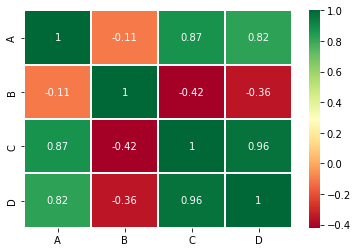

In [5]:
# Visulize correlation using seaborn
sns.heatmap(compounds.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)

Provided below is a pairplot, which shows the relationship between all the four features in a scatterplot. As described above, A and B have no defined cluster, but A compared with C and D as well as C and D compared with themselves also seem to have nice defined clusters. In contrast to what was noted above, B vs C and B vs D seem to have a decently defined clusters. I think the conclusion I reach is that if I were to test how well my model performs, the relationship between A and B might be interesting to view due to the ambiguity. However, the other relationships show a much clearer difference, so it might be an easier model to adapt to. 

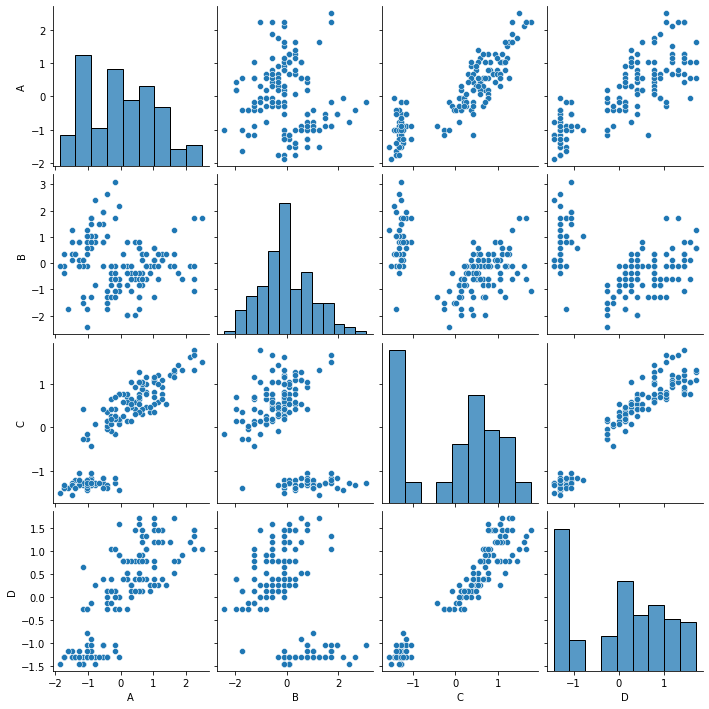

In [6]:
sns.pairplot(compounds_norm)

Provided below is just another way of visualizing heatmaps. The information is displayed is similar to what was displayed previously, just another way of showing the same information :) 

<AxesSubplot:>

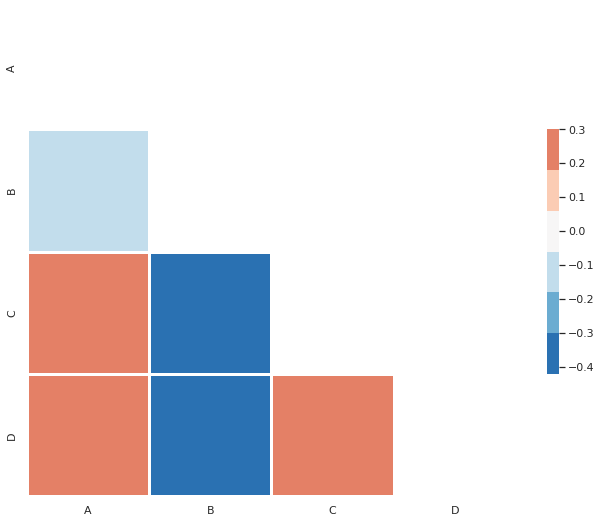

In [7]:
#plotting using mask technique
sns.set_theme(style="white")
corr = compounds.corr()
mask = np.triu(compounds.corr())
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("RdBu_r", 7)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=3, cbar_kws={"shrink": .5})

### Question b) 
Do KMeans clustering with K=2,3, and 4 clusters. Visualize your result (you can select 2 features to do visualization) adn comment on which K value make the most sense to you according to the visualization you see. (Use the provided code if you are a ugrad or fill int he code for Kmeans if you are a grad)

In [23]:
# use Kmeans for clustering
import warnings

class KMeans():
    def __init__(self, K, maximum_iters=100):
        # K: number of clusters to be created
        # distance matrix is Eucledian distance
        self.K = K
        self.maximum_iters = maximum_iters
    
    def cluster(self, input_points):
        """ Do KMeans clustering
        input_points: np.array shape(ndata,nfeatures). 
            Each feature is assumed to be normalized within range of [0,1]
        """
        centroids = np.random.random((self.K, input_points.shape[1]))
        assignments = np.zeros_like(input_points.shape[0])
        new_assignments = self.create_new_assignments(centroids, input_points)
        
        # restart if run into bad initialization
        # Comment out this part for Q1.(d)
        if len(np.unique(new_assignments))<self.K:
            return self.cluster(input_points)
        
        n_iters = 1
        while (new_assignments != assignments).any() and n_iters < self.maximum_iters:
            ### Compute the centroid given new assignment ###
            centroids = np.array([input_points[new_assignments==k].mean(axis=0) for k in range(self.K)])
            assignments = new_assignments
            ### Update the assignment with current centroids ###
            new_assignments = self.create_new_assignments(centroids, input_points)
            if len(np.unique(new_assignments))< self.K:
                warnings.warn('At least one centroid vanishes')
            n_iters += 1
            if n_iters == self.maximum_iters:
                print("Warning: Maximum number of iterations reached!")
                
        return new_assignments

    def create_new_assignments(self, centroids, data_points):
        """ Assign each datapoint to its nearest centroid.
        centroid: 2d array of the current centroid for each cluster
        data_points: 2d arrays recording the features of each data point.
        """
        ###Compute the distances that stores the Eucledian distances between each datapoints and the centroid ###
        #shape (ndata,ncentroid)
        distances = distance.cdist(data_points, centroids) 
        new_assignments = np.argmin(distances, axis=-1)
        return new_assignments

In [24]:
def validate(y_hat,y):
    """print accuracy of prediction for each class for the compounds dataset
    yhat: np.array shape(ndata). Your prediction of classes
    y: np.array of str shape(ndata). data labels / groudn truths.
    """
    # correct classification
    compounds = np.unique(y) # should be ['amide','phenol','ether'] for compounds dataset
    clusters =[np.where((y==c)) for c in compounds]
    pred_class = np.unique(y_hat)
    
    #remove -1 for noise point in DBSCAN
    pred_class= np.delete(pred_class,np.where(pred_class==-1))
    assert len(pred_class) == len(compounds), f'y_hat has less or more than {len(compounds)} classes:{pred_class}'

    for i in range(3):
        #loop over solutions
        counts=[]
        scores=[]
        for j in range(3):
            #loop over clusters of true assignments
            sol_i= np.where((y_hat==pred_class[i]))
            counts.append(len(np.intersect1d(sol_i, clusters[j])))
            scores.append(counts[-1]/len(clusters[j]))
        idx = np.argmax(scores)
        print(f'Class {pred_class[i]} - {compounds[idx]}: {counts[idx]} out \
of {np.count_nonzero(clusters[idx])} are classified correctly')

The following graph shows the correlation between A and B features using K Means of 2. It seems that there is a really nice separation between the two clusters, however as it will be shown soon that this is not the true separation as there are 3 groups that the data points needed to be separated to. Visuallly however, this seems to work nicely. 

In [40]:
model = KMeans(2)
cpds = compounds_norm.to_numpy()
assignments = KMeans.cluster(model, cpds)

[Text(0.5, 1.0, 'A vs B using K=2')]

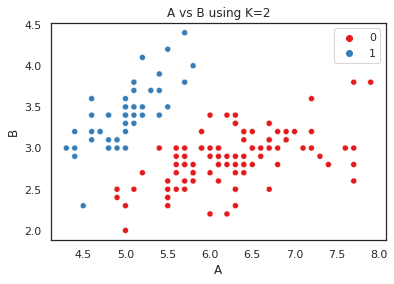

In [41]:
sns.scatterplot(data=compounds, x='A', y='B', hue=assignments, palette='Set1').set(title='A vs B using K=2')

The following graph shows the assignment of labels between A and B features using the K = 3 values. The separation of one of the clusters is really well done but there is overlap between the other two clusters, which makes this clustering a little unrealiable. That being said, when compared with the true value as shown right below this graph, the separation between amide and either is ambiguous to begin with (as mentioned previously with the correlation graphs shown above). Given the ambiguity, I think the K Means algorithm performed decently enough with about 65% of the labels correctly assigned for group 0 and 36% well assigned for group 1. 

As a conclusion, given the unreliable and ambigious input, I think the algorithm did fairly well but there might be better algorithms that can do a better job labeling the clusters, if perfect labels were expected. 

In [125]:
model = KMeans(3)
cpds = compounds_norm.to_numpy()
assignments = KMeans.cluster(model, cpds)

[Text(0.5, 1.0, 'A vs B using K=3')]

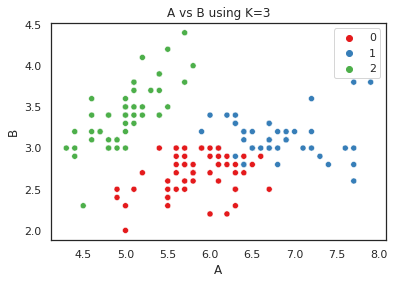

In [126]:
sns.scatterplot(data=compounds, x='A', y='B', hue=assignments, palette='Set1').set(title='A vs B using K=3')

[Text(0.5, 1.0, 'A vs B using K=3 (true labels)')]

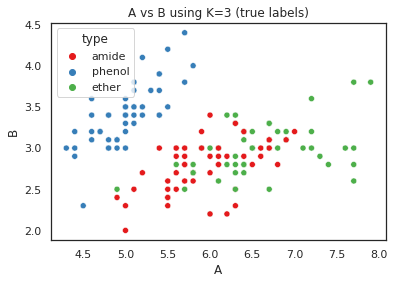

In [127]:
sns.scatterplot(data=compounds, x='A', y='B', hue=compounds['type'], palette='Set1').set(title='A vs B using K=3 (true labels)')

In [46]:
validate(assignments, compounds['type'])

Class 0 - phenol: 32 out of 50 are classified correctly
Class 1 - phenol: 18 out of 50 are classified correctly
Class 2 - ether: 50 out of 50 are classified correctly


The following graph shows the labels based on K = 4 values. This time none of the clusters were well organized and there is a lot of overlap between all of the groups, even the groups that are clearly separated from others. 

In [128]:
model = KMeans(4)
cpds = compounds_norm.to_numpy()
assignments = KMeans.cluster(model, cpds)

[Text(0.5, 1.0, 'A vs B using K=4')]

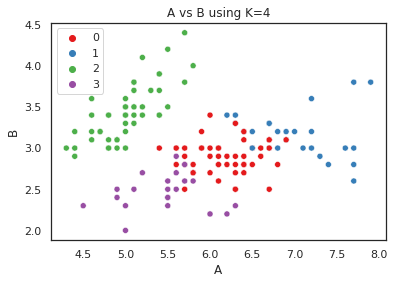

In [129]:
sns.scatterplot(data=compounds, x='A', y='B', hue=assignments, palette='Set1').set(title='A vs B using K=4')

### Question c) 
For K = 3 clustering result, compare it to the true data label. How good is the classification? 

This answer was previously answered when comparing K = 3, here is the excerpt pasted again. 

when compared with the true value as shown right below this graph, the separation between amide and either is ambiguous to begin with (as mentioned previously with the correlation graphs shown above). Given the ambiguity, I think the K Means algorithm performed decently enough with about 65% of the labels correctly assigned for group 0 and 36% well assigned for group 1.

As a conclusion, given the unreliable and ambigious input, I think the algorithm did fairly well but there might be better algorithms that can do a better job labeling the clusters, if perfect labels were expected.

If I were to use any of the features like A vs C or C vs D, I am sure the result must have been much more reliable. 

### Question d) 

Comment out the part of the code that reintialize the centroid if the initial assignment is not good Run the KMEans algorithms multoiple times with K=4, what problem do you see? Comment on how the choice of intial centroids might affect the results and waht are the possible solutions. 

In [103]:
# use Kmeans for clustering
import warnings

class KMeans():
    def __init__(self, K, maximum_iters=100):
        # K: number of clusters to be created
        # distance matrix is Eucledian distance
        self.K = K
        self.maximum_iters = maximum_iters
    
    def cluster(self, input_points):
        """ Do KMeans clustering
        input_points: np.array shape(ndata,nfeatures). 
            Each feature is assumed to be normalized within range of [0,1]
        """
        centroids = np.random.random((self.K, input_points.shape[1]))
        assignments = np.zeros_like(input_points.shape[0])
        new_assignments = self.create_new_assignments(centroids, input_points)
        
        # restart if run into bad initialization
        # Comment out this part for Q1.(d)
        # if len(np.unique(new_assignments))<self.K:
        #     return self.cluster(input_points)
        
        n_iters = 1
        while (new_assignments != assignments).any() and n_iters < self.maximum_iters:
            ### Compute the centroid given new assignment ###
            centroids = np.array([input_points[new_assignments==k].mean(axis=0) for k in range(self.K)])
            assignments = new_assignments
            ### Update the assignment with current centroids ###
            new_assignments = self.create_new_assignments(centroids, input_points)
            if len(np.unique(new_assignments))< self.K:
                warnings.warn('At least one centroid vanishes')
            n_iters += 1
            if n_iters == self.maximum_iters:
                print("Warning: Maximum number of iterations reached!")
                
        return new_assignments

    def create_new_assignments(self, centroids, data_points):
        """ Assign each datapoint to its nearest centroid.
        centroid: 2d array of the current centroid for each cluster
        data_points: 2d arrays recording the features of each data point.
        """
        ###Compute the distances that stores the Eucledian distances between each datapoints and the centroid ###
        #shape (ndata,ncentroid)
        distances = distance.cdist(data_points, centroids) 
        new_assignments = np.argmin(distances, axis=-1)
        return new_assignments

In [122]:
model = KMeans(4)
cpds = compounds_norm.to_numpy()
assignments = KMeans.cluster(model, cpds)
print(assignments)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


<ipython-input-103-ed8c654742cf>:28: RuntimeWarning: Mean of empty slice.
  centroids = np.array([input_points[new_assignments==k].mean(axis=0) for k in range(self.K)])
<ipython-input-103-ed8c654742cf>:33: UserWarning: At least one centroid vanishes
  warnings.warn('At least one centroid vanishes')


As shown above, after multiple runs of the model, the assignments were labeled such that each value got the same label. This is due to how the intiial centroids were chosen. If the initial centroids were chosen such that one of the centroids was in a closer proximity to all the points and all the clusters were extremely far away, this leads to a scenario where all the points end up getting assigne to the same one cluster. Thus, it is important to make sure that the initial centroids are not randomly chosen but that there is more thought gone into what positions to initialize with

In [246]:
from sklearn.cluster import DBSCAN

cpds = compounds_norm.to_numpy()
db = DBSCAN(eps=0.40, min_samples=7)
clustering = db.fit(cpds)
# Indices of core samples.
clustering.core_sample_indices_
# Cluster labels for each point in the dataset given to fit().  Noisy samples are given the label -1.
clustering.labels_

unique, counts = np.unique(clustering.labels_, return_counts=True)
print("Unique points:", unique)
print("The counts: ", counts)
print("The total number of core points: ", len(clustering.core_sample_indices_))

#To find the number of border values 
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

# find the indices of all points that are neither -1 nor core samples
border_samples_mask = (clustering.labels_ != -1) & (~core_samples_mask)
border_samples_indices = np.where(border_samples_mask)[0]

# count the number of border samples
num_border_samples = len(border_samples_indices)

print(f"Number of border samples: {num_border_samples}")

Unique points: [-1  0  1  2]
The counts:  [110  15  18   7]
The total number of core points:  22
Number of border samples: 18


[Text(0.5, 1.0, 'A vs B using DBSCAN')]

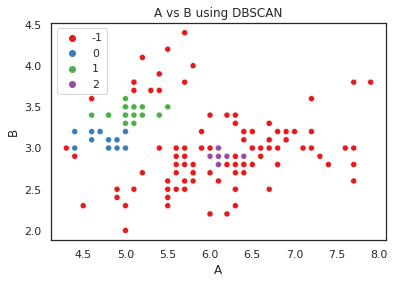

In [247]:
sns.scatterplot(data=compounds, x='A', y='B', hue=clustering.labels_, palette='Set1').set(title='A vs B using DBSCAN')

As shown above, the eps had to be set to 0.50 and the min samples was set to 11 for the model to produce 3 clusters. In these three clusters, the majority were noisy points with 110 points being noise. There were a total of 22 core points and about 18 border points. Looking at the provided graph, I believe KMeans did much better with K = 3 (here, noise is not counted as a separate cluster) than DBSCAN in categorizing the given data. Alhtough the given input was ambigous to begin with, KMeans had improved classification than DBSCAN. 


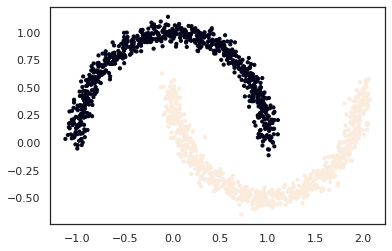

In [211]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from pylab import *

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
# print(noisy_moons)
X,y=noisy_moons
plt.scatter(X[:, 0], X[:, 1], s=10,c=y)

In [221]:
db = DBSCAN(eps=0.11, min_samples=6)
clustering = db.fit(X)
# Indices of core samples.
clustering.core_sample_indices_
# Cluster labels for each point in the dataset given to fit().  Noisy samples are given the label -1.
clustering.labels_

print(np.unique(clustering.labels_))

[-1  0  1]


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'DBSCAN for noisy moon data')]

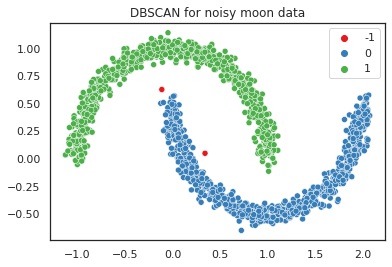

In [227]:
sns.scatterplot(X[:, 0], X[:, 1], hue=clustering.labels_, palette='Set1').set(title='DBSCAN for noisy moon data')

In [228]:
model = KMeans(2)
assignments = KMeans.cluster(model, X)
print(assignments)

[0 1 0 ... 0 0 1]


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'KMeans for noisy moon data')]

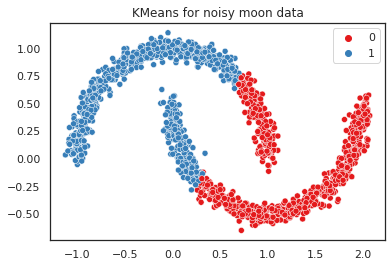

In [230]:
sns.scatterplot(X[:, 0], X[:, 1], hue=assignments, palette='Set1').set(title='KMeans for noisy moon data')

In this case, DBSCAN did much better in predicting the clusters accurately. This is because KMeans is a protoype based cluster and DBSCAN is a density based cluster. This means that KMeans has difficulty with globular or multiple sizes of of clusters but DBSCAN tends to do better in these scenarios and is not motivated by outliers or noises. 